In [1]:
#importing libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from itertools import product
from st_dbscan import ST_DBSCAN
from pyproj import CRS
from pyproj import Transformer
import plotly.express as px

In [2]:
#adding data
data_1 = pd.read_csv('sept_2020.csv')
data_2 = pd.read_csv('oct_2020.csv')
data_3 = pd.read_csv('nov_2020.csv')
data_4 = pd.read_csv('dec_2020.csv')

## Pre-processing data
Data is available for entire mid-lands, filtering data for Birmingham

In [3]:
data = pd.concat([ data_1, data_2 ,data_3, data_4])

In [4]:
data.columns

Index(['Crime ID', 'Month', 'Reported by', 'Falls within', 'Longitude',
       'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Crime type',
       'Last outcome category', 'Context'],
      dtype='object')

In [5]:
data = data.drop(data.columns[[0,2,3,10,11]], axis=1)

In [6]:
data

Month  Longitude   Latitude                    Location  LSOA code  \
0      2020-09  -0.198566  51.643150     On or near Meadow Close  E01000289   
1      2020-09  -0.195913  51.621132        On or near Shortgate  E01000276   
2      2020-09  -0.195913  51.621132        On or near Shortgate  E01000276   
3      2020-09  -0.195913  51.621132        On or near Shortgate  E01000276   
4      2020-09  -1.850772  52.588691  On or near Seymour Gardens  E01009417   
...        ...        ...        ...                         ...        ...   
29945  2020-12  -2.124530  52.581482     On or near Parking Area  E01010530   
29946  2020-12  -2.124530  52.581482     On or near Parking Area  E01010530   
29947  2020-12  -2.115234  52.582031  On or near Commercial Road  E01010530   
29948  2020-12  -2.118379  52.582702      On or near Bath Street  E01010530   
29949  2020-12  -1.940575  52.226551      On or near Mearse Lane  E01032392   

                LSOA name                    Crime type  
0             Barnet 004D  Violence and sexual offences  
1             Barnet 020A                      Burglary  
2             Barnet 020A                       Robbery  
3             Barnet 020A                       Robbery  
4         Birmingham 001A         Anti-social behaviour  
...                   ...                           ...  
29945  Wolverhampton 035H  Violence and sexual offences  
29946  Wolverhampton 035H  Violence and sexual offences  
29947  Wolverhampton 035H  Violence and sexual offences  
29948  Wolverhampton 035H  Violence and sexual offences  
29949       Wychavon 008A         Theft from the person  

[118643 rows x 7 columns]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118643 entries, 0 to 29949
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Month       118643 non-null  object 
 1   Longitude   118643 non-null  float64
 2   Latitude    118643 non-null  float64
 3   Location    118643 non-null  object 
 4   LSOA code   118640 non-null  object 
 5   LSOA name   118640 non-null  object 
 6   Crime type  118643 non-null  object 
dtypes: float64(2), object(5)
memory usage: 7.2+ MB


In [8]:
null_data = data[data.isnull().any(axis=1)]
null_data

Month  Longitude   Latitude              Location LSOA code  \
28173  2020-09  -7.547692  54.517074           On or near        NaN   
28174  2020-09  -7.547692  54.517074           On or near        NaN   
29909  2020-10  -7.570955  54.520635  On or near Tedd Road       NaN   

      LSOA name                    Crime type  
28173       NaN                       Robbery  
28174       NaN  Violence and sexual offences  
29909       NaN                      Burglary

In [9]:
data = data[data['LSOA code'].notna()]
data

Month  Longitude   Latitude                    Location  LSOA code  \
0      2020-09  -0.198566  51.643150     On or near Meadow Close  E01000289   
1      2020-09  -0.195913  51.621132        On or near Shortgate  E01000276   
2      2020-09  -0.195913  51.621132        On or near Shortgate  E01000276   
3      2020-09  -0.195913  51.621132        On or near Shortgate  E01000276   
4      2020-09  -1.850772  52.588691  On or near Seymour Gardens  E01009417   
...        ...        ...        ...                         ...        ...   
29945  2020-12  -2.124530  52.581482     On or near Parking Area  E01010530   
29946  2020-12  -2.124530  52.581482     On or near Parking Area  E01010530   
29947  2020-12  -2.115234  52.582031  On or near Commercial Road  E01010530   
29948  2020-12  -2.118379  52.582702      On or near Bath Street  E01010530   
29949  2020-12  -1.940575  52.226551      On or near Mearse Lane  E01032392   

                LSOA name                    Crime type  
0             Barnet 004D  Violence and sexual offences  
1             Barnet 020A                      Burglary  
2             Barnet 020A                       Robbery  
3             Barnet 020A                       Robbery  
4         Birmingham 001A         Anti-social behaviour  
...                   ...                           ...  
29945  Wolverhampton 035H  Violence and sexual offences  
29946  Wolverhampton 035H  Violence and sexual offences  
29947  Wolverhampton 035H  Violence and sexual offences  
29948  Wolverhampton 035H  Violence and sexual offences  
29949       Wychavon 008A         Theft from the person  

[118640 rows x 7 columns]

In [10]:
data['LSOA name'].nunique()

1811

In [11]:
data =data[data['LSOA name'].str.startswith('Birmingham')]
data

Month  Longitude   Latitude                          Location  \
4      2020-09  -1.850772  52.588691        On or near Seymour Gardens   
5      2020-09  -1.845780  52.593827             On or near Hook Drive   
6      2020-09  -1.840641  52.598270      On or near Badgers Bank Road   
7      2020-09  -1.841944  52.597265          On or near Chelsea Drive   
8      2020-09  -1.841944  52.597265          On or near Chelsea Drive   
...        ...        ...        ...                               ...   
13315  2020-12  -1.861053  52.450735          On or near Avondale Road   
13316  2020-12  -1.846173  52.447418  On or near New Imperial Crescent   
13317  2020-12  -1.858491  52.451227             On or near Percy Road   
13318  2020-12  -1.861491  52.451608            On or near Evelyn Road   
13319  2020-12  -1.857743  52.450444          On or near Shopping Area   

       LSOA code        LSOA name                    Crime type  
4      E01009417  Birmingham 001A         Anti-social behaviour  
5      E01009418  Birmingham 001B         Anti-social behaviour  
6      E01009418  Birmingham 001B         Anti-social behaviour  
7      E01009418  Birmingham 001B         Anti-social behaviour  
8      E01009418  Birmingham 001B         Anti-social behaviour  
...          ...              ...                           ...  
13315  E01033641  Birmingham 140G  Violence and sexual offences  
13316  E01033641  Birmingham 140G  Violence and sexual offences  
13317  E01033641  Birmingham 140G  Violence and sexual offences  
13318  E01033641  Birmingham 140G  Violence and sexual offences  
13319  E01033641  Birmingham 140G  Violence and sexual offences  

[52979 rows x 7 columns]

## EDA: Crime Type

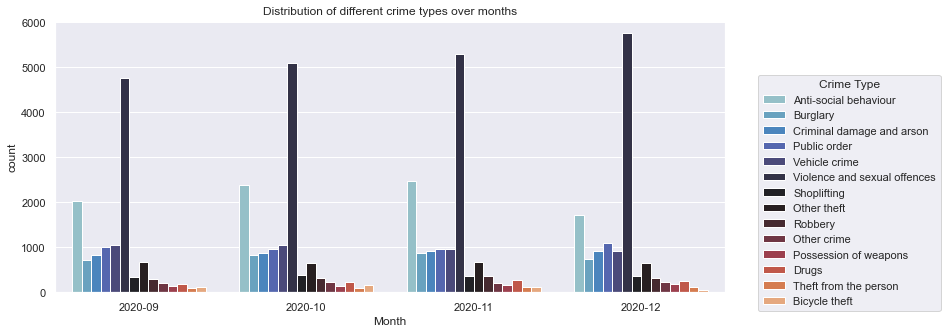

In [12]:
sns.set(rc={'figure.figsize': (12,5)})
g = sns.countplot(x = 'Month', data = data, hue = 'Crime type', palette= 'icefire').set(title='Distribution of different crime types over months')
plt.legend(bbox_to_anchor=(1.05, 0.8), loc='upper left', borderaxespad=0, title='Crime Type')

 From the graph above, it is evident that violence and sexual offences is dominant type of crime in Birmingham and it has increasing trend over the months. Second most dominant crime is anti-social behaviour. Therefore, violence and sexual offences was choosen for this study.

In [13]:
vso =data[data['Crime type'].str.startswith('Violence')]
vso

Month  Longitude   Latitude                          Location  \
15     2020-09  -1.843740  52.594588          On or near Clarence Road   
16     2020-09  -1.841944  52.597265          On or near Chelsea Drive   
22     2020-09  -1.841844  52.600474          On or near Kestrel Drive   
23     2020-09  -1.841844  52.600474          On or near Kestrel Drive   
26     2020-09  -1.835413  52.590810             On or near Sara Close   
...        ...        ...        ...                               ...   
13315  2020-12  -1.861053  52.450735          On or near Avondale Road   
13316  2020-12  -1.846173  52.447418  On or near New Imperial Crescent   
13317  2020-12  -1.858491  52.451227             On or near Percy Road   
13318  2020-12  -1.861491  52.451608            On or near Evelyn Road   
13319  2020-12  -1.857743  52.450444          On or near Shopping Area   

       LSOA code        LSOA name                    Crime type  
15     E01009418  Birmingham 001B  Violence and sexual offences  
16     E01009418  Birmingham 001B  Violence and sexual offences  
22     E01009433  Birmingham 001D  Violence and sexual offences  
23     E01009433  Birmingham 001D  Violence and sexual offences  
26     E01009415  Birmingham 002A  Violence and sexual offences  
...          ...              ...                           ...  
13315  E01033641  Birmingham 140G  Violence and sexual offences  
13316  E01033641  Birmingham 140G  Violence and sexual offences  
13317  E01033641  Birmingham 140G  Violence and sexual offences  
13318  E01033641  Birmingham 140G  Violence and sexual offences  
13319  E01033641  Birmingham 140G  Violence and sexual offences  

[20912 rows x 7 columns]

In [14]:
vso.to_csv('4months.csv', index_label='index')
vso.head()

Month  Longitude   Latitude                  Location  LSOA code  \
15  2020-09  -1.843740  52.594588  On or near Clarence Road  E01009418   
16  2020-09  -1.841944  52.597265  On or near Chelsea Drive  E01009418   
22  2020-09  -1.841844  52.600474  On or near Kestrel Drive  E01009433   
23  2020-09  -1.841844  52.600474  On or near Kestrel Drive  E01009433   
26  2020-09  -1.835413  52.590810     On or near Sara Close  E01009415   

          LSOA name                    Crime type  
15  Birmingham 001B  Violence and sexual offences  
16  Birmingham 001B  Violence and sexual offences  
22  Birmingham 001D  Violence and sexual offences  
23  Birmingham 001D  Violence and sexual offences  
26  Birmingham 002A  Violence and sexual offences

In [15]:
vso.index = np.arange(1,len(vso) + 1)
vso

Month  Longitude   Latitude                          Location  \
1      2020-09  -1.843740  52.594588          On or near Clarence Road   
2      2020-09  -1.841944  52.597265          On or near Chelsea Drive   
3      2020-09  -1.841844  52.600474          On or near Kestrel Drive   
4      2020-09  -1.841844  52.600474          On or near Kestrel Drive   
5      2020-09  -1.835413  52.590810             On or near Sara Close   
...        ...        ...        ...                               ...   
20908  2020-12  -1.861053  52.450735          On or near Avondale Road   
20909  2020-12  -1.846173  52.447418  On or near New Imperial Crescent   
20910  2020-12  -1.858491  52.451227             On or near Percy Road   
20911  2020-12  -1.861491  52.451608            On or near Evelyn Road   
20912  2020-12  -1.857743  52.450444          On or near Shopping Area   

       LSOA code        LSOA name                    Crime type  
1      E01009418  Birmingham 001B  Violence and sexual offences  
2      E01009418  Birmingham 001B  Violence and sexual offences  
3      E01009433  Birmingham 001D  Violence and sexual offences  
4      E01009433  Birmingham 001D  Violence and sexual offences  
5      E01009415  Birmingham 002A  Violence and sexual offences  
...          ...              ...                           ...  
20908  E01033641  Birmingham 140G  Violence and sexual offences  
20909  E01033641  Birmingham 140G  Violence and sexual offences  
20910  E01033641  Birmingham 140G  Violence and sexual offences  
20911  E01033641  Birmingham 140G  Violence and sexual offences  
20912  E01033641  Birmingham 140G  Violence and sexual offences  

[20912 rows x 7 columns]

In [16]:
# Transforming latlong to easting and northing 
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:27700')

In [17]:
vso['Easting'], vso['Northing'] = transformer.transform(vso['Latitude'].values, vso['Longitude'].values)
vso

n:\development\other\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Month  Longitude   Latitude                          Location  \
1      2020-09  -1.843740  52.594588          On or near Clarence Road   
2      2020-09  -1.841944  52.597265          On or near Chelsea Drive   
3      2020-09  -1.841844  52.600474          On or near Kestrel Drive   
4      2020-09  -1.841844  52.600474          On or near Kestrel Drive   
5      2020-09  -1.835413  52.590810             On or near Sara Close   
...        ...        ...        ...                               ...   
20908  2020-12  -1.861053  52.450735          On or near Avondale Road   
20909  2020-12  -1.846173  52.447418  On or near New Imperial Crescent   
20910  2020-12  -1.858491  52.451227             On or near Percy Road   
20911  2020-12  -1.861491  52.451608            On or near Evelyn Road   
20912  2020-12  -1.857743  52.450444          On or near Shopping Area   

       LSOA code        LSOA name                    Crime type  \
1      E01009418  Birmingham 001B  Violence and sexual offences   
2      E01009418  Birmingham 001B  Violence and sexual offences   
3      E01009433  Birmingham 001D  Violence and sexual offences   
4      E01009433  Birmingham 001D  Violence and sexual offences   
5      E01009415  Birmingham 002A  Violence and sexual offences   
...          ...              ...                           ...   
20908  E01033641  Birmingham 140G  Violence and sexual offences   
20909  E01033641  Birmingham 140G  Violence and sexual offences   
20910  E01033641  Birmingham 140G  Violence and sexual offences   
20911  E01033641  Birmingham 140G  Violence and sexual offences   
20912  E01033641  Birmingham 140G  Violence and sexual offences   

             Easting       Northing  
1      410682.008919  299654.972520  
2      410803.017113  299953.019434  
3      410809.009179  300309.994964  
4      410809.009179  300309.994964  
5      411247.030819  299235.970715  
...              ...            ...  
20908  409539.976571  283650.951716  
20909  410552.018309  283284.031478  
20910  409713.985367  283706.016352  
20911  409510.023943  283748.002488  
20912  409764.990662  283619.019288  

[20912 rows x 9 columns]

## Pre-processing shapefile

In [18]:
west_midlands_shp = gpd.read_file('2021_06_08_Initial_Proposals_West_Midlands.shp')

<AxesSubplot:>

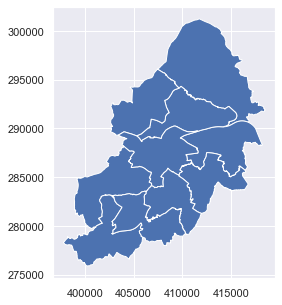

In [19]:
birm_boroughs = ['Sutton Coldfield', 'Birmingham Hodge Hill', 'Birmingham Erdington','Birmingham Perry Barr', 'Birmingham Ladywood','Birmingham Edgbaston','Birmingham Yardley','Birmingham Hall Green','Birmingham Northfield','Birmingham Selly Oak'] 
bs_to_chk = west_midlands_shp['Constituen']
for i in bs_to_chk:
    if i not in birm_boroughs:
        west_midlands_shp.drop(west_midlands_shp[west_midlands_shp['Constituen'] == i].index[0], inplace=True)
west_midlands_shp.plot()

In [20]:
west_midlands_shp.to_file('birmingham')

In [21]:
pts = pd.DataFrame({'latitude': vso['Latitude'].to_list(), 'longitude': vso['Longitude'].to_list()})
geometry = gpd.points_from_xy(pts['latitude'], pts['longitude'])

In [22]:
west_midlands_shp = gpd.read_file('birmingham')
bir_shp = west_midlands_shp
bir_shp

Constituen  Electorate            Designatio  \
0       Sutton Coldfield     74584.0  Borough Constituency   
1  Birmingham Hodge Hill     76922.0  Borough Constituency   
2   Birmingham Erdington     75925.0  Borough Constituency   
3  Birmingham Perry Barr     74979.0  Borough Constituency   
4    Birmingham Ladywood     76585.0  Borough Constituency   
5   Birmingham Edgbaston     71354.0  Borough Constituency   
6     Birmingham Yardley     71912.0  Borough Constituency   
7  Birmingham Hall Green     75781.0  Borough Constituency   
8  Birmingham Northfield     73483.0  Borough Constituency   
9   Birmingham Selly Oak     76285.0  Borough Constituency   

                 Region  Region_ID  Area_Km2  Density  \
0  West Midlands Region        5.0     57.70  1292.62   
1  West Midlands Region        5.0     24.69  3115.51   
2  West Midlands Region        5.0     24.14  3145.19   
3  West Midlands Region        5.0     25.78  2908.42   
4  West Midlands Region        5.0     25.70  2979.96   
5  West Midlands Region        5.0     29.61  2409.79   
6  West Midlands Region        5.0     19.84  3624.60   
7  West Midlands Region        5.0     19.36  3914.31   
8  West Midlands Region        5.0     24.94  2946.39   
9  West Midlands Region        5.0     21.68  3518.68   

                                            geometry  
0  POLYGON Z ((415677.299 296216.998 0.000, 41569...  
1  POLYGON Z ((415879.699 286138.003 0.000, 41587...  
2  POLYGON Z ((405608.703 289364.600 0.000, 40563...  
3  POLYGON Z ((405608.703 289364.600 0.000, 40557...  
4  POLYGON Z ((406745.103 284819.401 0.000, 40669...  
5  POLYGON Z ((401709.399 282224.104 0.000, 40171...  
6  POLYGON Z ((411977.600 281270.896 0.000, 41197...  
7  POLYGON Z ((410338.400 279207.597 0.000, 41033...  
8  POLYGON Z ((400009.300 276168.797 0.000, 40000...  
9  POLYGON Z ((409295.202 279228.701 0.000, 40924...

### KERNEL DENSITY ESTIMATION (KDE)

In [23]:
# dividing data into different months for KDE plot
sep_20 = vso.iloc[:4767,]
oct_20 = vso.iloc[4767:9859,]
nov_20 = vso.iloc[9859:15161,]
dec_20 = vso.iloc[15161:,]

In [26]:
#function to plot KDE for different months
def kde(data,month,num):
    i, num = plt.subplots(1, figsize=(7, 7))
    bir_shp.plot(color='white', edgecolor='black',ax=num)
    sns.kdeplot( ax=num,x=data['Easting'],y=data['Northing'],data=data, fill=True, cmap='mako', alpha = 0.5, cbar=True,).set(title ='Violence and Sexual offence in Birmingham,' + str(month));
    plt.show()


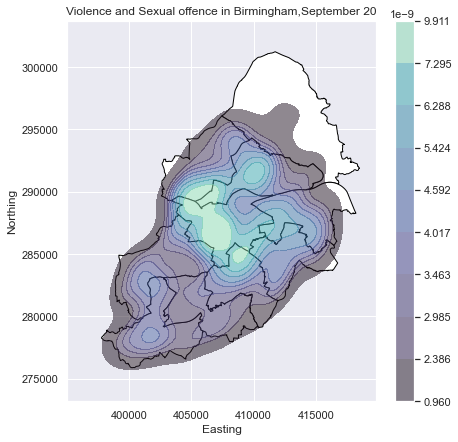

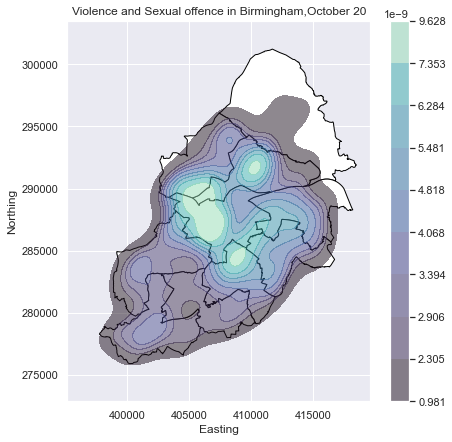

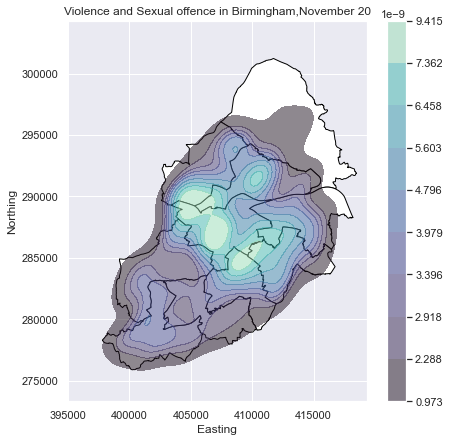

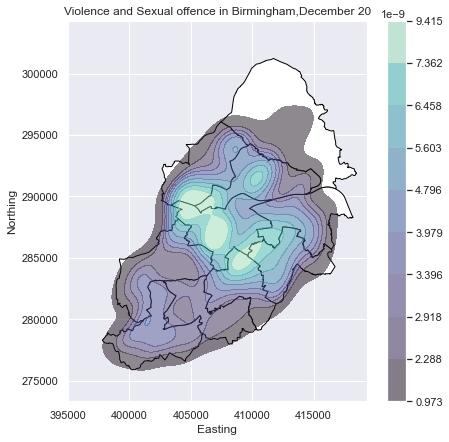

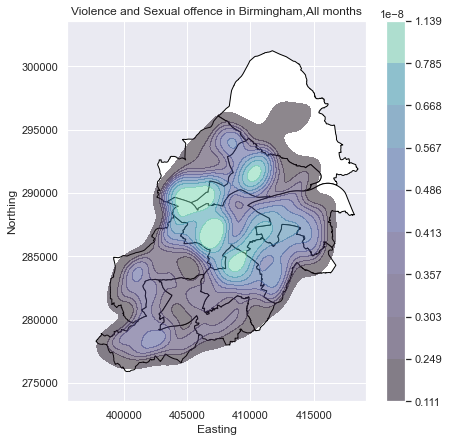

In [28]:
#callinf kde function to plot 
kde(sep_20, 'September 20', 1)
kde(oct_20, 'October 20', 2)
kde(nov_20, 'November 20', 3)
kde(nov_20, 'December 20', 4)
kde(vso, 'All months', 5)

## Making data suitable for clustering

In [29]:
# converting months to numricals
vso['Month'] = [str(i).replace("2020-09", "1") for i in vso['Month']]
vso['Month'] = [str(i).replace("2020-10", "2") for i in vso['Month']]
vso['Month'] = [str(i).replace("2020-11", "3") for i in vso['Month']]
vso['Month'] = [str(i).replace("2020-12", "4") for i in vso['Month']]

n:\development\other\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
n:\development\other\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
n:\development\other\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [30]:
vso_final = vso.drop(vso.columns[[1,2,3,4,5,6]], axis=1)
vso_final

Month        Easting       Northing
1         1  410682.008919  299654.972520
2         1  410803.017113  299953.019434
3         1  410809.009179  300309.994964
4         1  410809.009179  300309.994964
5         1  411247.030819  299235.970715
...     ...            ...            ...
20908     4  409539.976571  283650.951716
20909     4  410552.018309  283284.031478
20910     4  409713.985367  283706.016352
20911     4  409510.023943  283748.002488
20912     4  409764.990662  283619.019288

[20912 rows x 3 columns]

In [31]:
# interactive Spatial-temporal data visualation
df = vso
fig = px.scatter_3d(df, x='Easting', y='Northing', z='Month',
              color='Month')
fig.show()

In [32]:
#converting dataframe to array
vso_array = vso_final.to_numpy()
vso_array

array([['1', 410682.0089185123, 299654.9725202032],
       ['1', 410803.017112856, 299953.01943358144],
       ['1', 410809.00917911285, 300309.99496368825],
       ...,
       ['4', 409713.9853666977, 283706.0163523782],
       ['4', 409510.02394349297, 283748.002487895],
       ['4', 409764.9906624334, 283619.01928767445]], dtype=object)

# Clustering

In [33]:
# Source:https://github.com/eren-ck/st_dbscan/blob/master/demo/demo.ipynb

def plot(vso_array, labels, title):
    colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
    bir_shp.plot(color='white', edgecolor='black')
    
    plt.grid()
    for i in range(-1, len(set(labels))):
        if i == -1:
            col = [0, 0, 0, 1]
        else:
            col = colors[i % len(colors)]
        
        clust = vso_array[np.where(labels==i)]
    
        plt.title( title)
        plt.scatter(clust[:,0], clust[:,1], c=[col], s=10,)
        
    
    plt.show()
    

#### DBSCAN

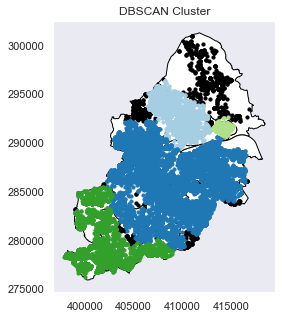

In [34]:
dbscan_model= DBSCAN(eps=845, min_samples=155, metric='euclidean' ).fit(vso_final)   
plot(vso_array[:,1:3], dbscan_model.labels_, 'DBSCAN Cluster') 

#### ST-DBSCAN

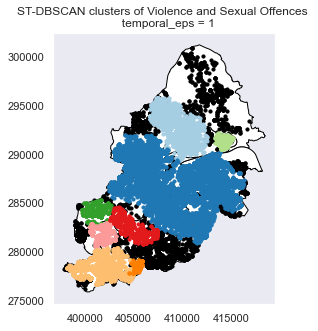

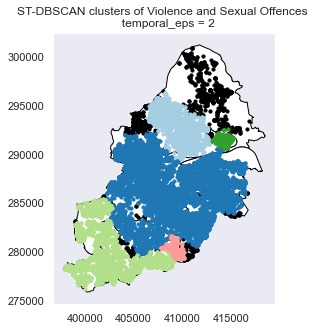

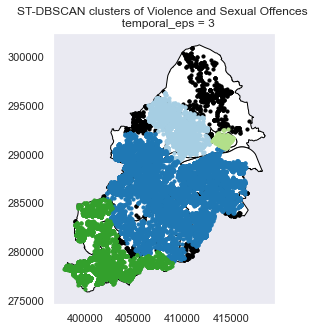

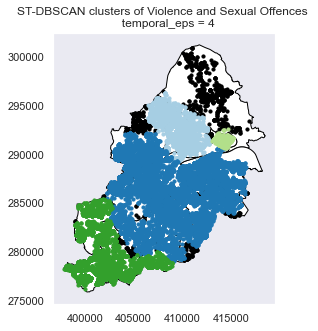

In [35]:
temporal_eps=[1,2,3,4]
for st_eps2 in temporal_eps:
    st_dbscan = ST_DBSCAN(eps1 = 845, eps2 = st_eps2, min_samples = 155) 
    st_dbscan.fit(vso_array) 
    plot(vso_array[:,1:3], st_dbscan.labels,'ST-DBSCAN clusters of Violence and Sexual Offences \n'+'  temporal_eps = ' + str(st_eps2)) 

The number of clusters formed and shape of clusters keep changing

##### Tunning hyper-parameters of DBSCAN using silhouette score

The parameter was tunned by exploring various combination; it may take time to run this!!!
Source: https://towardsdatascience.com/explaining-dbscan-clustering-18eaf5c83b31

In [36]:
pca_eps_values = np.arange(700,1200,20) 
pca_min_samples = np.arange(400, 700, 50)
pca_dbscan_params = list(product(pca_eps_values, pca_min_samples))
pca_no_of_clusters = []
pca_db_index = []
pca_epsvalues = []
pca_min_samp = []
for p in pca_dbscan_params:
    pca_dbscan_cluster = DBSCAN(eps=p[0], min_samples=p[1]).fit(vso_final)
    pca_epsvalues.append(p[0])
    pca_min_samp.append(p[1])
    pca_no_of_clusters.append(len(np.unique(pca_dbscan_cluster.labels_)))
    pca_db_index.append(silhouette_score(vso_final, pca_dbscan_cluster.labels_))
pca_eps_min = list(zip(pca_no_of_clusters, pca_db_index, pca_epsvalues, pca_min_samp))
pca_eps_min_df = pd.DataFrame(pca_eps_min, columns=['no_of_clusters', 'silhouette score', 'epsilon_values', 'minimum_points'])
pca_eps_min_df

no_of_clusters  silhouette score  epsilon_values  minimum_points
0                 6         -0.269515             700             400
1                 4         -0.283566             700             450
2                 2         -0.231190             700             500
3                 2         -0.233981             700             550
4                 2         -0.238891             700             600
..              ...               ...             ...             ...
145               5          0.077613            1180             450
146               3          0.182441            1180             500
147               5         -0.001177            1180             550
148               3          0.058858            1180             600
149               3          0.042139            1180             650

[150 rows x 4 columns]

In [138]:
pca_eps_values = np.arange(700,1000,20) 
pca_min_samples = np.arange(400, 600, 50)
pca_dbscan_params = list(product(pca_eps_values, pca_min_samples))
pca_no_of_clusters = []
pca_db_index = []
pca_epsvalues = []
pca_min_samp = []
for p in pca_dbscan_params:
    pca_dbscan_cluster = DBSCAN(eps=p[0], min_samples=p[1]).fit(vso_final)
    pca_epsvalues.append(p[0])
    pca_min_samp.append(p[1])
    pca_no_of_clusters.append(len(np.unique(pca_dbscan_cluster.labels_)))
    pca_db_index.append(silhouette_score(vso_final, pca_dbscan_cluster.labels_))
pca_eps_min = list(zip(pca_no_of_clusters, pca_db_index, pca_epsvalues, pca_min_samp))
pca_eps_min_df = pd.DataFrame(pca_eps_min, columns=['no_of_clusters', 'silhouette score', 'epsilon values', 'minimum points'])
pca_eps_min_df

no_of_clusters       sil  epsilon_values  minimum_points
0                6 -0.269515             700             400
1                4 -0.283566             700             450
2                2 -0.231190             700             500
3                2 -0.233981             700             550
4                5 -0.230788             720             400
5                6 -0.297777             720             450
6                2 -0.224785             720             500
7                2 -0.232153             720             550
8                5 -0.196772             740             400
9                6 -0.281348             740             450
10               4 -0.274069             740             500
11               2 -0.228696             740             550
12               5 -0.171139             760             400
13               5 -0.228164             760             450
14               5 -0.302634             760             500
15               2 -0.223514             760             550
16               5 -0.153177             780             400
17               5 -0.195827             780             450
18               6 -0.273119             780             500
19               3 -0.290715             780             550
20               6 -0.141318             800             400
21               5 -0.168567             800             450
22               5 -0.224622             800             500
23               4 -0.262196             800             550
24               7 -0.114815             820             400
25               5 -0.146705             820             450
26               5 -0.193026             820             500
27               5 -0.280847             820             550
28               7 -0.096530             840             400
29               5 -0.135364             840             450
30               5 -0.169173             840             500
31               6 -0.248878             840             550
32               7 -0.077224             860             400
33               6 -0.133198             860             450
34               5 -0.147496             860             500
35               5 -0.190890             860             550
36               5 -0.022939             880             400
37               6 -0.118897             880             450
38               5 -0.132657             880             500
39               5 -0.160998             880             550
40               6 -0.186837             900             400
41               6 -0.094321             900             450
42               5 -0.124468             900             500
43               5 -0.142914             900             550
44               4  0.046439             920             400
45               3 -0.005594             920             450
46               6 -0.124926             920             500
47               5 -0.133614             920             550
48               5 -0.043765             940             400
49               4 -0.050054             940             450
50               5 -0.123765             940             500
51               5 -0.121517             940             550
52               5 -0.033722             960             400
53               4 -0.035165             960             450
54               5 -0.112981             960             500
55               5 -0.114636             960             550
56               5 -0.026094             980             400
57               4  0.040426             980             450
58               3 -0.007469             980             500
59               6 -0.115446             980             550

In [110]:
pca_eps_values = np.arange(1500,2000,100) 
pca_min_samples = np.arange(300, 500, 50)
pca_dbscan_params = list(product(pca_eps_values, pca_min_samples))
pca_no_of_clusters = []
pca_db_index = []
pca_epsvalues = []
pca_min_samp = []
for p in pca_dbscan_params:
    pca_dbscan_cluster = DBSCAN(eps=p[0], min_samples=p[1]).fit(vso_final)
    pca_epsvalues.append(p[0])
    pca_min_samp.append(p[1])
    pca_no_of_clusters.append(len(np.unique(pca_dbscan_cluster.labels_)))
    pca_db_index.append(silhouette_score(vso_final, pca_dbscan_cluster.labels_))
pca_eps_min = list(zip(pca_no_of_clusters, pca_db_index, pca_epsvalues, pca_min_samp))
pca_eps_min_df = pd.DataFrame(pca_eps_min, columns=['no_of_clusters', 'silhouette score', 'epsilon values', 'minimum points'])
pca_eps_min_df

no_of_clusters       sil  epsilon_values  minimum_points
0                2  0.338990            1500             300
1                2  0.333549            1500             350
2                2  0.322673            1500             400
3                2  0.304510            1500             450
4                3  0.294191            1600             300
5                2  0.338765            1600             350
6                2  0.334135            1600             400
7                2  0.326404            1600             450
8                2  0.381728            1700             300
9                2  0.340917            1700             350
10               2  0.338201            1700             400
11               2  0.333047            1700             450
12               2  0.390262            1800             300
13               2  0.346381            1800             350
14               2  0.343216            1800             400
15               2  0.338848            1800             450
16               2  0.393256            1900             300
17               2  0.350756            1900             350
18               2  0.348267            1900             400
19               2  0.344123            1900             450

If increase the epsilon values, silhouette score increases however it decreases the cluster to 2 i.e. only 1 cluster; other is noise. Therefore, need to decrease the epsilon value

In [124]:
pca_eps_values = np.arange(800,900,10) 
pca_min_samples = np.arange(150, 180, 10)
pca_dbscan_params = list(product(pca_eps_values, pca_min_samples))
pca_no_of_clusters = []
pca_db_index = []
pca_epsvalues = []
pca_min_samp = []
for p in pca_dbscan_params:
    pca_dbscan_cluster = DBSCAN(eps=p[0], min_samples=p[1]).fit(vso_final)
    pca_epsvalues.append(p[0])
    pca_min_samp.append(p[1])
    pca_no_of_clusters.append(len(np.unique(pca_dbscan_cluster.labels_)))
    pca_db_index.append(silhouette_score(vso_final, pca_dbscan_cluster.labels_))
pca_eps_min = list(zip(pca_no_of_clusters, pca_db_index, pca_epsvalues, pca_min_samp))
pca_eps_min_df = pd.DataFrame(pca_eps_min, columns=['no_of_clusters', 'sil', 'epsilon_values', 'minimum_points'])
pca_eps_min_df

no_of_clusters       sil  epsilon_values  minimum_points
0                7  0.040498             800             150
1                8  0.010732             800             160
2               10 -0.063786             800             170
3                7  0.039605             810             150
4                7  0.026065             810             160
5                8  0.005212             810             170
6                7  0.041164             820             150
7                7  0.035310             820             160
8                8  0.008642             820             170
9                4  0.144445             830             150
10               6  0.058347             830             160
11               8  0.014846             830             170
12               3  0.104249             840             150
13               6  0.059584             840             160
14               8  0.015159             840             170
15               4 -0.068474             850             150
16               5  0.177642             850             160
17               7  0.030741             850             170
18               2  0.286980             860             150
19               4  0.143441             860             160
20               6  0.060696             860             170
21               2  0.294209             870             150
22               3  0.108762             870             160
23               6  0.062745             870             170
24               3  0.245937             880             150
25               2  0.274337             880             160
26               5  0.017819             880             170
27               3  0.251760             890             150
28               2  0.291682             890             160
29               3  0.107830             890             170

In [125]:
pca_eps_values = np.arange(845,870,5) 
pca_min_samples = np.arange(150, 170, 5)
pca_dbscan_params = list(product(pca_eps_values, pca_min_samples))
pca_no_of_clusters = []
pca_db_index = []
pca_epsvalues = []
pca_min_samp = []
for p in pca_dbscan_params:
    pca_dbscan_cluster = DBSCAN(eps=p[0], min_samples=p[1]).fit(vso_final)
    pca_epsvalues.append(p[0])
    pca_min_samp.append(p[1])
    pca_no_of_clusters.append(len(np.unique(pca_dbscan_cluster.labels_)))
    pca_db_index.append(silhouette_score(vso_final, pca_dbscan_cluster.labels_))
pca_eps_min = list(zip(pca_no_of_clusters, pca_db_index, pca_epsvalues, pca_min_samp))
pca_eps_min_df = pd.DataFrame(pca_eps_min, columns=['no_of_clusters', 'silhouette score', 'epsilon_values', 'minimum_points'])
pca_eps_min_df

no_of_clusters       sil  epsilon_values  minimum_points
0                4 -0.069378             845             150
1                5  0.178690             845             155
2                6  0.064549             845             160
3                6  0.059140             845             165
4                4 -0.068474             850             150
5                4  0.126968             850             155
6                5  0.177642             850             160
7                6  0.059762             850             165
8                3  0.114345             855             150
9                3  0.107832             855             155
10               4  0.142060             855             160
11               6  0.060196             855             165
12               2  0.286980             860             150
13               3  0.108356             860             155
14               4  0.143441             860             160
15               6  0.064582             860             165
16               2  0.290861             865             150
17               3  0.109370             865             155
18               3  0.106056             865             160
19               6  0.064893             865             165

In [129]:
pca_eps_values = np.arange(820,845,5) 
pca_min_samples = np.arange(150, 170, 5)
pca_dbscan_params = list(product(pca_eps_values, pca_min_samples))
pca_no_of_clusters = []
pca_db_index = []
pca_epsvalues = []
pca_min_samp = []
for p in pca_dbscan_params:
    pca_dbscan_cluster = DBSCAN(eps=p[0], min_samples=p[1]).fit(vso_final)
    pca_epsvalues.append(p[0])
    pca_min_samp.append(p[1])
    pca_no_of_clusters.append(len(np.unique(pca_dbscan_cluster.labels_)))
    pca_db_index.append(silhouette_score(vso_final, pca_dbscan_cluster.labels_))
pca_eps_min = list(zip(pca_no_of_clusters, pca_db_index, pca_epsvalues, pca_min_samp))
pca_eps_min_df = pd.DataFrame(pca_eps_min, columns=['no_of_clusters', 'sil', 'epsilon_values', 'minimum_points'])
pca_eps_min_df

no_of_clusters       sil  epsilon_values  minimum_points
0                7  0.041164             820             150
1                7  0.037004             820             155
2                7  0.035310             820             160
3                7  0.026966             820             165
4                6  0.064143             825             150
5                7  0.038855             825             155
6                7  0.036499             825             160
7                7  0.031526             825             165
8                4  0.144445             830             150
9                6  0.059060             830             155
10               6  0.058347             830             160
11               7  0.030225             830             165
12               3  0.103559             835             150
13               6  0.059353             835             155
14               6  0.059132             835             160
15               7  0.030726             835             165
16               3  0.104249             840             150
17               6  0.063050             840             155
18               6  0.059584             840             160
19               6  0.058580             840             165

Here, the number of cluster increases if decrease the episilon size however, the silhouette score decreases as well. 